# Data Gathering

In [1]:
%matplotlib inline

In [2]:
from utils.io import gdf_viewer, gdf_merger, data_validation, gdf_filter, fix_duplicates
import re, os
import numpy as np
import geopandas as gpd
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt
from definitions import ROOT_DIR

In [3]:
def files_search(work_dir, files_dict, prefix='', skip=None, details=False):   
    
    if skip is None:
        skip = "we don't want to skip a word"
        
    for k in files_dict.keys():
        tmp_list = []
        for p,d,f in os.walk(work_dir):
            for x in f:
                add = False
                if re.search(prefix,x,re.I) and not re.search(skip,x,re.I):
                    add = True
                    i = str(f'{p}/{x}')
                else:
                    add = False
                    i=''
                    
                if re.search(k,i,re.I) and add:
                    tmp_list.append(i)
        tmp_list.sort()
        files_dict.update({k:tmp_list})

    for k,v in files_dict.items():
        print(k,' \t: ',len(v))
    
    if details: # Look filenames
        which = files_dict.keys()

        for w in which:
            print('\n+++++++++++++++++')
            print(f'+  {w.upper()}\t+ ')
            print('+++++++++++++++++')
            [print(i, '-', x) for i, x in enumerate(files_dict[w], 0)]    


In [4]:
def create_df(files, verbose=True): # find another name for this function
    """
    create dataframes from files and test if they contain position informations
    files: list of files name
    """
    cnt = 0
    dfs = []
    for f in files:
        cnt += 1
        df = pd.read_csv(f, delimiter=',')
        dfs.append(df)
        
        if verbose:
            if 'X' in list(df.columns): msg = ' --> Coordinates'
            else: msg = ' --> No coordinates'

            print(f"df{cnt} : {msg}")
            
    return dfs

In [5]:
def dataset_overview(d, verbose=False): # check for same datasets in given files
    """d: dict
    """
    l = len(d)
    with_coord = []
    no_coord = []
    same = []
    
    for i in range(l-1):
        for j in range(i,l):
            a, b = create_df([d[i], d[j]], verbose)
            if j != i:
                if a.equals(b):
                    same.append((i,j))
            
            if 'X' in list(b.columns) and j not in with_coord:
                with_coord.append(j)
            elif 'X' not in list(b.columns) and j not in no_coord:
                no_coord.append(j)
    
    print(f'Same files:{same}\nFiles with coordinates:{with_coord}\nFiles without coordinates:{no_coord}')

## Reading files

In [6]:
work_dir = ROOT_DIR+'/CF_data/Result_traitem/'
save_dir = ROOT_DIR+'/CF_data/Donnees_fusionnees/'

In [7]:
# create my dictionary structure to retrieve good files (Keynames !!!)
files_dict={'Borehole':0,'Piezometer':0,'Piezair':0,'Trench':0,'Litho':0,'Equipm':0,
        'Measure':0,'Sample':0,'Analysis':0,'Facility':0}

In [8]:
files_search(work_dir, files_dict, prefix='', skip='source')

Borehole  	:  7
Piezometer  	:  17
Piezair  	:  2
Trench  	:  1
Litho  	:  7
Equipm  	:  3
Measure  	:  6
Sample  	:  27
Analysis  	:  21
Facility  	:  4


In [9]:
how=['inner', 'outer', 'left', 'right']

In [10]:
f = False
t = True

# Boreholes

In [11]:
file = save_dir+'Merged_Boreholes.csv'
bh = pd.read_csv(file, delimiter=',')
gdf_viewer(bh, rows=3, un_val='ID', view=t)

Rows : 235, columns : 20, Unique col 'ID': 235


interactive(children=(IntSlider(value=3, description='rows', max=235, min=3, readout=False), IntSlider(value=1…

# Lithologies

In [12]:
key='Litho'
save_file = f'Merged_Lithologies.csv'
coi = ['ID','X','Y','Z','Long_for','Description','Litho_top','Litho_base']
dataset = pd.DataFrame() # for saving object info after last merging
print(len(files_dict[key]), 'files')

7 files


In [13]:
files_dict[key] #files_dict[key][0]

['/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/database_Memoris3/Drains_Pz_ENEL_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/database_Memoris3/Profils_sol_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/database_Memoris3/Result_sol_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/donnees_terrain_2019/Log_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/Log_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/vUmons_logsFor/Sond2017v2_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/vUmons_logsFor/Synthese_Lithology.csv']

In [14]:
dataset_overview(files_dict[key])

Same files:[]
Files with coordinates:[2, 5, 6]
Files without coordinates:[0, 1, 3, 4]


#### $\color{green}{\textbf{Read and merge}}$

In [15]:
file1= work_dir + 'database_Memoris3/Drains_Pz_ENEL_Lithology.csv' # 0
file2= work_dir + 'database_Memoris3/Result_sol_Lithology.csv' # 2

df1, df2 = create_df([file1, file2])
gdf_viewer(df1, rows=3, un_val='ID', view=t), gdf_viewer(df2, rows=3, un_val='ID', view=t)

df1 :  --> No coordinates
df2 :  --> Coordinates
Rows : 1626, columns : 10, Unique col 'ID': 298


interactive(children=(IntSlider(value=3, description='rows', max=1626, min=3, readout=False), IntSlider(value=…

Rows : 1423, columns : 14, Unique col 'ID': 330


interactive(children=(IntSlider(value=3, description='rows', max=1423, min=3, readout=False), IntSlider(value=…

(None, None)

In [16]:
df1.rename(columns={'Profondeur':'Long_for'}, inplace=True)
df2.rename(columns={'Long':'Long_for', 'Description':'Description2'}, inplace=True)

In [17]:
df2['X'] = df2['X'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
df2['Y'] = df2['Y'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
df2['Ep_remb'] = df2['Ep_remb'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

In [18]:
df2[['X','Y','Ep_remb']] = df2[['X','Y','Ep_remb']].astype(float)

In [19]:
df1 = df1[['ID','Date_ouv','Long_for','Description','Litho_top','Litho_base']].copy()
df2 = df2[['ID','X','Y','Z','Long_for']].copy()

In [20]:
mdf, conflict_df = gdf_merger(df1, df2, how=how[1], on='ID', dist_max=1., drop_skip_col=['index'])

Conflict values present. Please resolve this manually !


In [21]:
gdf_viewer(mdf, rows=10, un_val='ID', view=t)

Rows : 1765, columns : 10, Unique col 'ID': 404


interactive(children=(IntSlider(value=10, description='rows', max=1765, min=10, readout=False), IntSlider(valu…

#### $\color{blue}{\textbf{Manage conflicts}}$

In [22]:
gdf_viewer(conflict_df, rows=10, un_val='ID', view=t)

Rows : 108, columns : 4, Unique col 'ID': 15


interactive(children=(IntSlider(value=10, description='rows', max=108, min=10, readout=False), IntSlider(value…

#### First object dataset save

In [23]:
dataset = mdf.copy() #saving

#### $\color{green}{\textbf{Read and merge}}$

In [24]:
file1= work_dir + 'database_Memoris3/Profils_sol_Lithology.csv' # 1
file2= work_dir + 'donnees_terrain_2019/Log_Lithology.csv' # 3

df1, df2 = create_df([file1, file2])
gdf_viewer(df1, rows=3, un_val='ID', view=t), gdf_viewer(df2, rows=3, un_val='ID', view=t)

df1 :  --> No coordinates
df2 :  --> No coordinates
Rows : 1626, columns : 10, Unique col 'ID': 298


interactive(children=(IntSlider(value=3, description='rows', max=1626, min=3, readout=False), IntSlider(value=…

Rows : 86, columns : 7, Unique col 'ID': 24


interactive(children=(IntSlider(value=3, description='rows', max=86, min=3, readout=False), IntSlider(value=7,…

(None, None)

In [25]:
for idx, row in df2.iterrows():
    if row['Type'] == 'Forage': 
        df2.loc[idx, 'Date_ouv']= '2019-10-07'
    elif row['Type'] == 'Piezo' or row['Type'] == 'Piezair': 
        df2.loc[idx, 'Date_ouv']= '2019-12-18'

In [26]:
df1.rename(columns={'Profondeur':'Long_for'}, inplace=True)
#df2.rename(columns={'Long':'Long_for', 'Description':'Description2'}, inplace=True)

In [27]:
df1 = df1[['ID','Date_ouv','Long_for','Description','Litho_top','Litho_base']].copy()
df2 = df2[['ID','Date_ouv','Description','Litho_top','Litho_base','Zone']].copy()

In [28]:
mdf, conflict_df = gdf_merger(df1, df2, how=how[1], on='ID', date_col='Date_ouv', dist_max=None, drop_skip_col=['index'])

In [29]:
gdf_viewer(mdf, rows=10, un_val='ID', view=t)

Rows : 1716, columns : 7, Unique col 'ID': 322


interactive(children=(IntSlider(value=10, description='rows', max=1716, min=10, readout=False), IntSlider(valu…

In [30]:
pause # problem with dataset merging

NameError: name 'pause' is not defined

#### Merge with object dataset

#### $\color{blue}{\textbf{Manage conflicts}}$

#### $\color{green}{\textbf{Read and merge}}$

#### $\color{blue}{\textbf{Manage conflicts}}$

#### Merge with object dataset

#### $\color{blue}{\textbf{Manage conflicts}}$

####  $\color{red}{\textbf{Save final object dataset}}$

#### -----------------------------------------------------------

## Plot

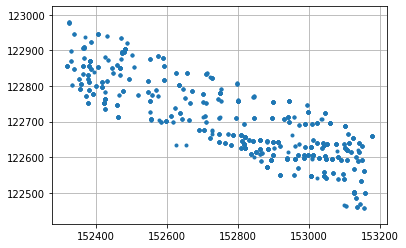

In [31]:
plt.plot(dataset['X'],dataset['Y'], '.')
plt.axis('equal')
plt.grid('on')

In [ ]:
pause